In [3]:
import pandas as pd
import numpy as np

In [4]:
train = pd.read_csv("../data/train.csv")

In [5]:
train[:5]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train = train.fillna("unknown")

In [7]:
target_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
num_classes = len(target_labels)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


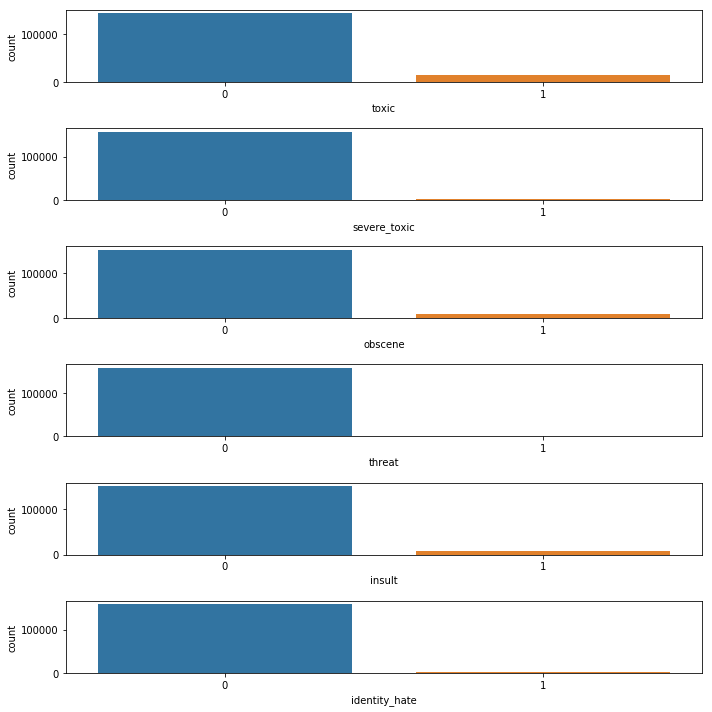

In [17]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, figsize=(10,10))
for label,ax in zip(target_labels,[ax1,ax2,ax3,ax4,ax5,ax6]):
    print(train[label].value_counts())
    sns.countplot(data=train, x=label, ax=ax, label=label)
    
plt.tight_layout()

In [18]:
test = pd.read_csv("../data/test.csv")

In [19]:
test[:5]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [20]:
test = test.fillna("unknown")

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_x = train["comment_text"]
train_x.shape

(159571,)

In [23]:
train_y = train.drop(["id", "comment_text"], axis=1)
train_y.shape

(159571, 6)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict

In [25]:
loss = []
preds_train = np.zeros((train_x.shape[0], len(target_labels)))

In [26]:
corpus = train["comment_text"].append(test["comment_text"])

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=10000)
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [28]:
scaler = MaxAbsScaler().fit(vectorizer.transform(corpus))

In [29]:
train_x_tf = vectorizer.transform(train_x)
train_x_tf[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49 stored elements in Compressed Sparse Row format>

In [30]:
train_x_tf = scaler.transform(train_x_tf)

In [31]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
def try_pipeline(pipeline, text="comment_text"):
    for label in target_labels:
        print("Fitting {}".format(label)),
        score = cross_val_score(pipeline, train[text], train_y[label], cv=5, scoring='neg_log_loss', n_jobs=-1)
        print("Score: {}".format(score))
   

    for label in target_labels:
        print("Displaying for {}".format(label)),
        pred = cross_val_predict(pipeline, train[text], train[label], cv=3, n_jobs=-1)
        print(accuracy_score(train[label], pred))
        plot_confusion_matrix(train[label], pred, classes=[0,1], normalize=True)

Fitting toxic
Score: [-0.11609442 -0.11797649 -0.11805486 -0.11707383 -0.11728729]
Fitting severe_toxic
Score: [-0.02780986 -0.02691682 -0.02855942 -0.02728568 -0.02701749]
Fitting obscene
Score: [-0.06807903 -0.06822473 -0.06479922 -0.06514008 -0.06668642]
Fitting threat
Score: [-0.01090047 -0.01050966 -0.01102593 -0.01102758 -0.01036314]
Fitting insult
Score: [-0.08096967 -0.08111206 -0.07934214 -0.07789241 -0.07908768]
Fitting identity_hate
Score: [-0.02729259 -0.02768115 -0.02832396 -0.02788954 -0.02745714]
Displaying for toxic
0.955662369729


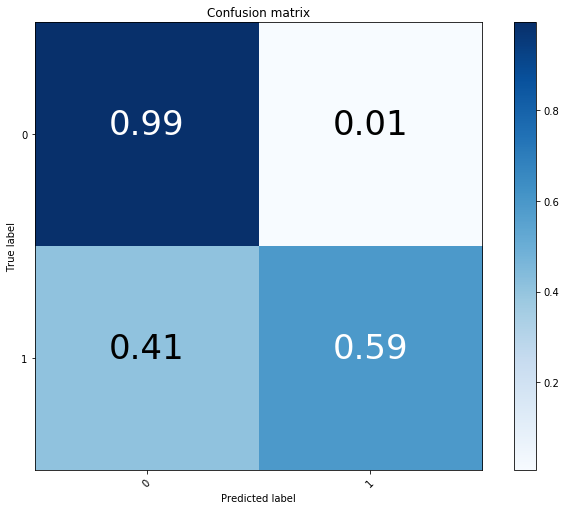

Displaying for severe_toxic
0.99072513176


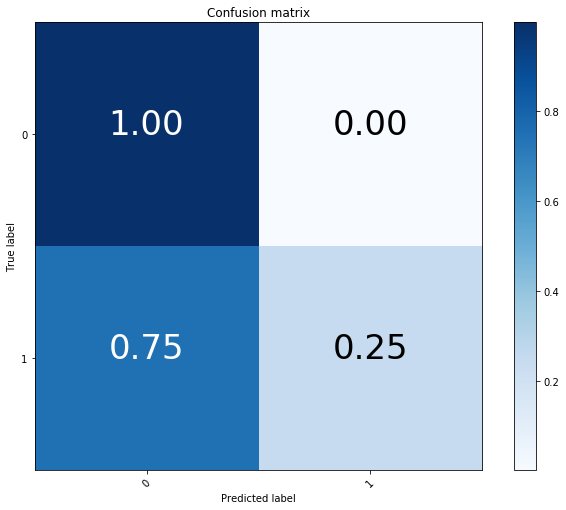

Displaying for obscene
0.97657469089


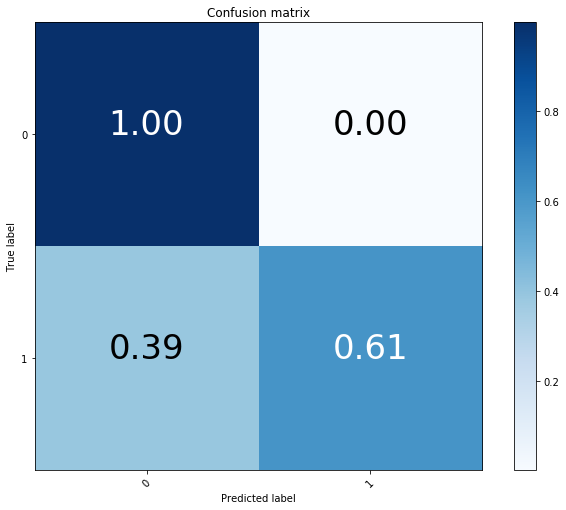

Displaying for threat
0.997198739119


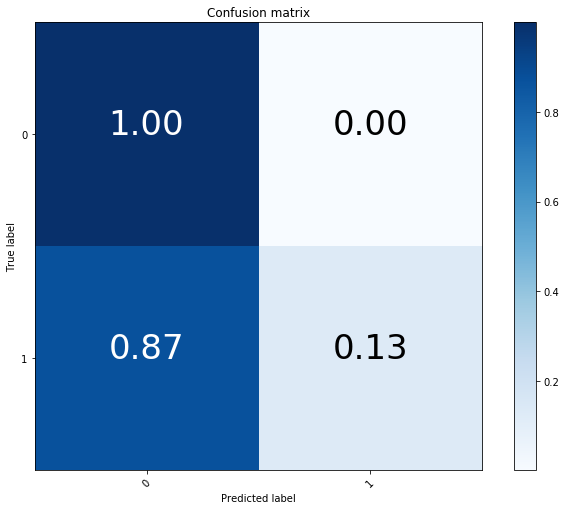

Displaying for insult
0.970614961365


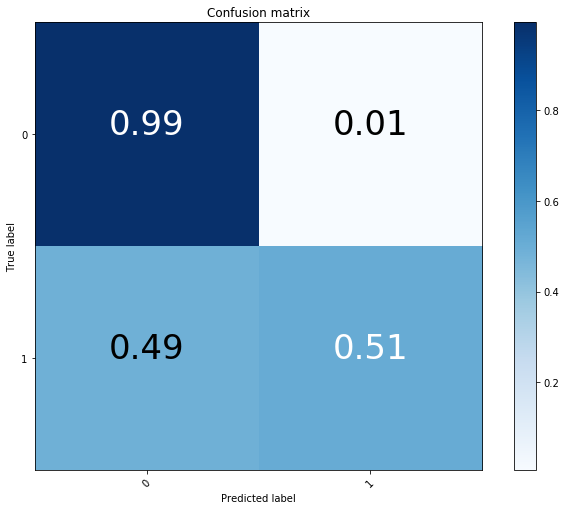

Displaying for identity_hate
0.991796755049


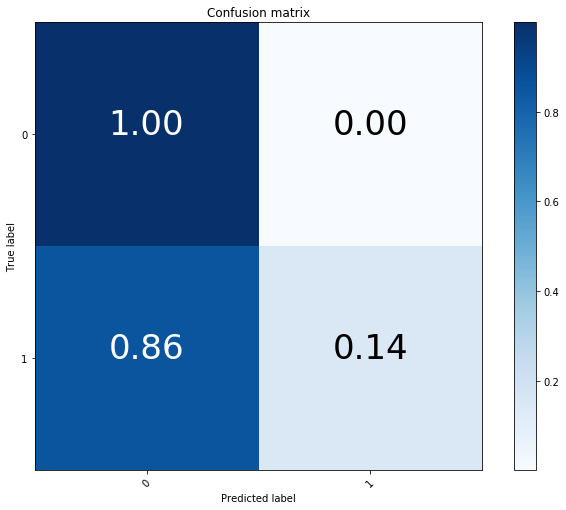

In [115]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("clf", LogisticRegression())
])

try_pipeline(pipeline)

Fitting toxic
Score: [-0.11329447 -0.114688   -0.11438285 -0.11292446 -0.11359165]
Fitting severe_toxic
Score: [-0.02753261 -0.02668141 -0.02822067 -0.02698599 -0.0277482 ]
Fitting obscene
Score: [-0.06672133 -0.06657713 -0.0627335  -0.06487874 -0.06602674]
Fitting threat
Score: [-0.01002414 -0.00945191 -0.01021967 -0.01002604 -0.00960138]
Fitting insult
Score: [-0.07868742 -0.07937747 -0.07688838 -0.0768505  -0.07727231]
Fitting identity_hate
Score: [-0.02597176 -0.02689964 -0.02742781 -0.02692165 -0.0263577 ]
Displaying for toxic
0.956915730302


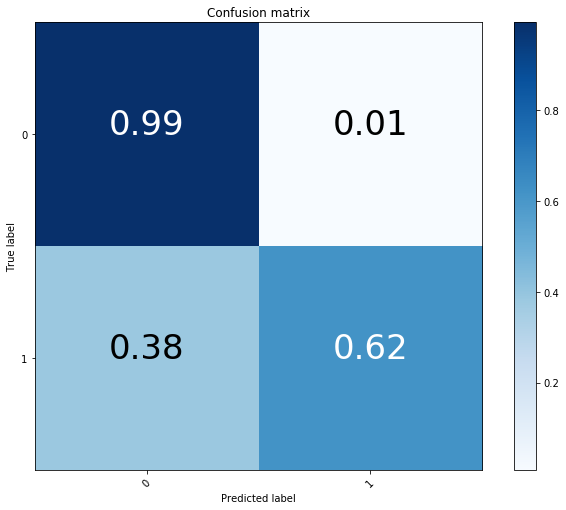

Displaying for severe_toxic
0.990530860871


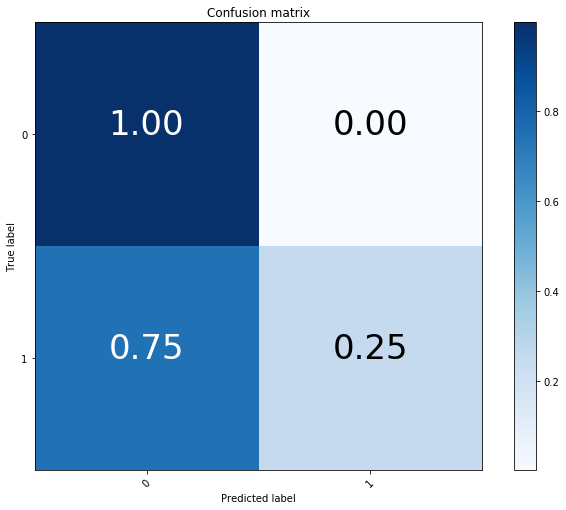

Displaying for obscene
0.97679402899


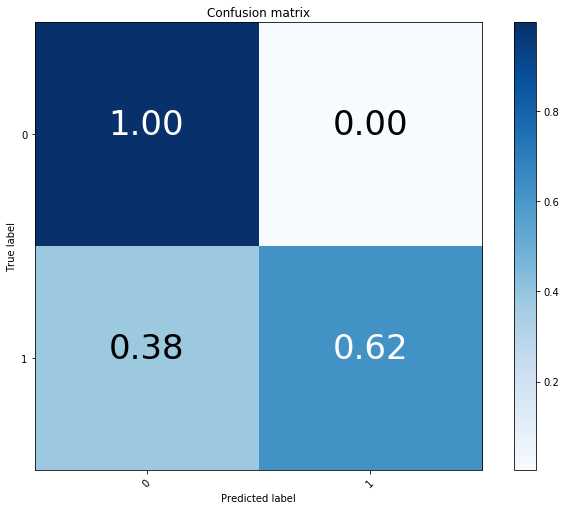

Displaying for threat
0.997223806331


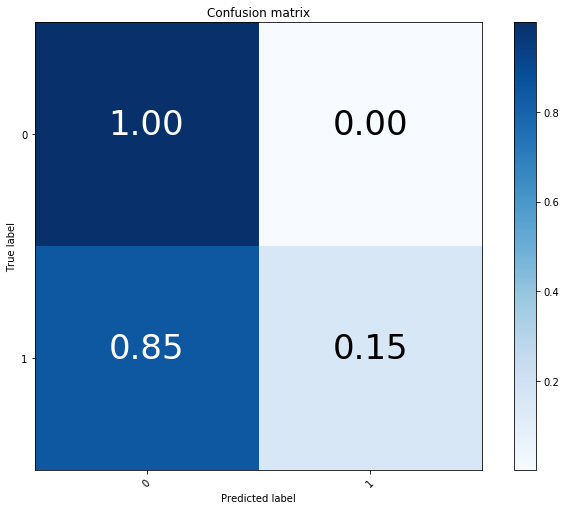

Displaying for insult
0.971210307637


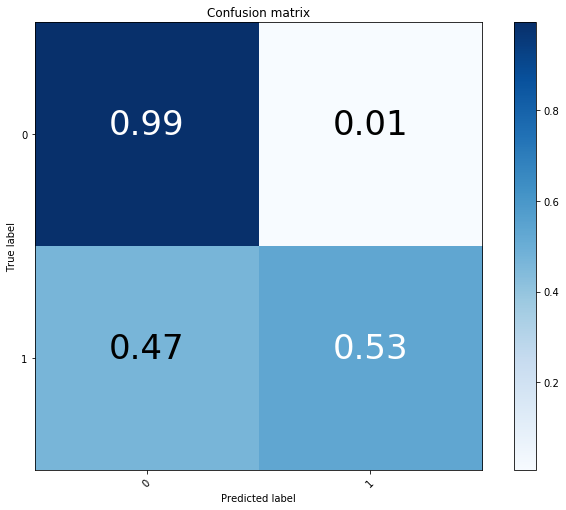

Displaying for identity_hate
0.991815555458


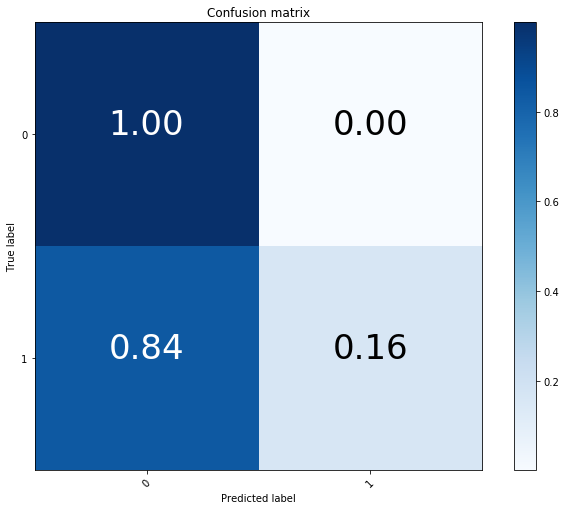

In [116]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("scaller", MaxAbsScaler()),
    ("clf", LogisticRegression())
])

try_pipeline(pipeline)

In [33]:
from sklearn.naive_bayes import MultinomialNB

Fitting toxic
Score: [-0.3781821  -0.39043581 -0.38745255 -0.39265952 -0.37958687]
Fitting severe_toxic
Score: [-0.13484858 -0.14089475 -0.13694561 -0.13398266 -0.13122695]
Fitting obscene
Score: [-0.31214918 -0.3298234  -0.31041371 -0.33099589 -0.31678458]
Fitting threat
Score: [-0.08036505 -0.07730821 -0.07425731 -0.08122185 -0.07440659]
Fitting insult
Score: [-0.30859203 -0.32481403 -0.32087388 -0.33002791 -0.32649694]
Fitting identity_hate
Score: [-0.14280594 -0.14668148 -0.14721542 -0.14693716 -0.14275664]
Displaying for toxic
0.918757167656


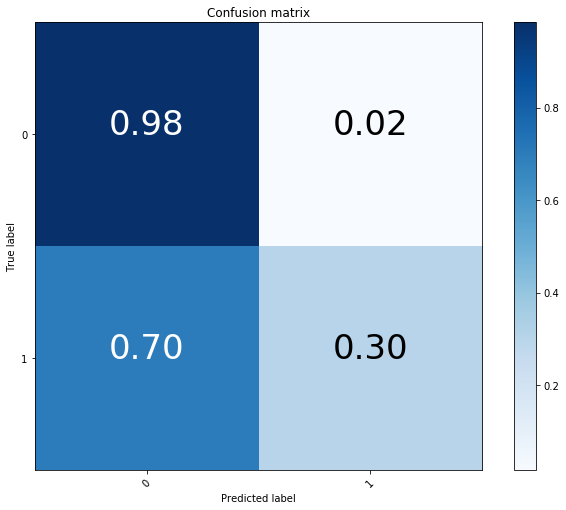

Displaying for severe_toxic
0.985003540744


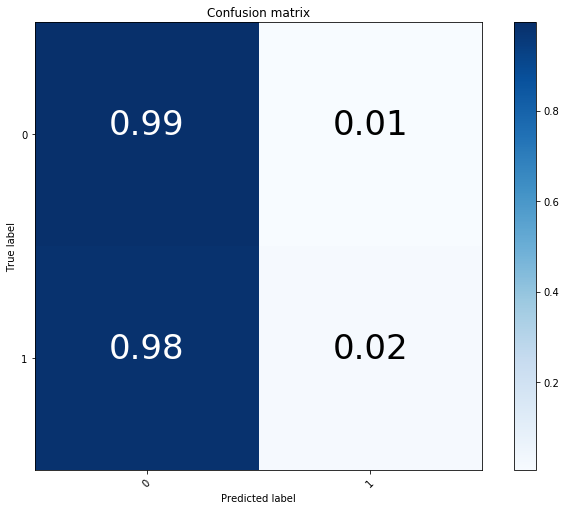

Displaying for obscene
0.947164585044


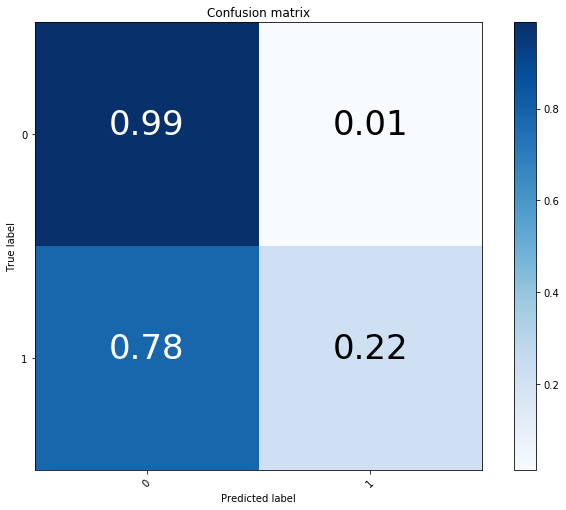

Displaying for threat
0.993463724612


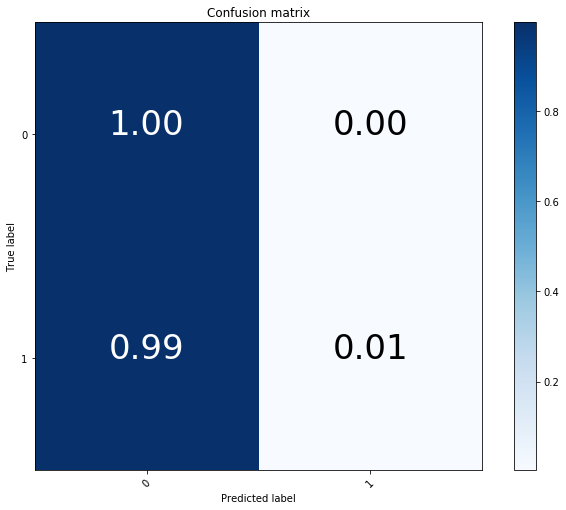

Displaying for insult
0.946863778506


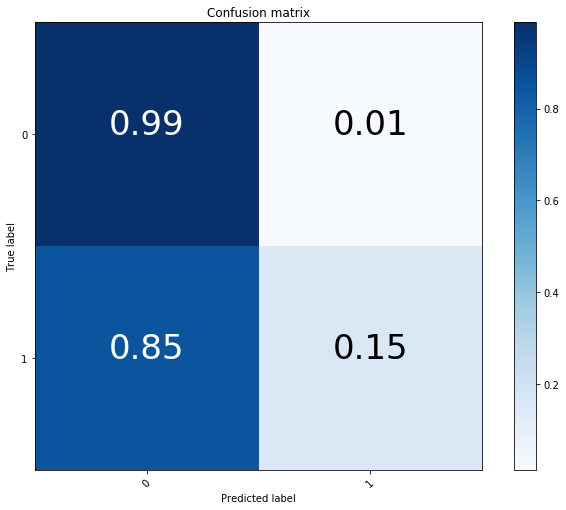

Displaying for identity_hate
0.986068897231


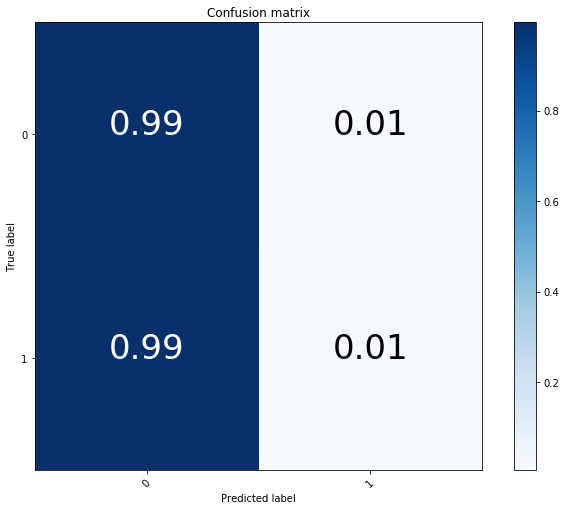

In [34]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("scaller", MaxAbsScaler()),
    ("clf", MultinomialNB())
])

try_pipeline(pipeline)

Fitting toxic
Score: [-0.3465717  -0.35577086 -0.35148497 -0.35462635 -0.35076766]
Fitting severe_toxic
Score: [-0.08877254 -0.09104312 -0.09379092 -0.08911164 -0.08777353]
Fitting obscene
Score: [-0.25497685 -0.26577913 -0.25434567 -0.26205332 -0.2580942 ]
Fitting threat
Score: [-0.04317034 -0.04065731 -0.03971031 -0.04654703 -0.0412636 ]
Fitting insult
Score: [-0.25998156 -0.26607323 -0.26577744 -0.26778315 -0.27102633]
Fitting identity_hate
Score: [-0.09395681 -0.09422556 -0.09762645 -0.09562174 -0.09389673]
Displaying for toxic
0.917842214437


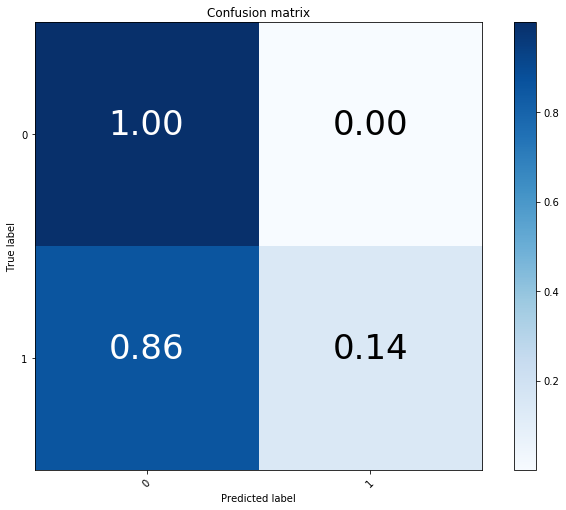

Displaying for severe_toxic
0.989991915824


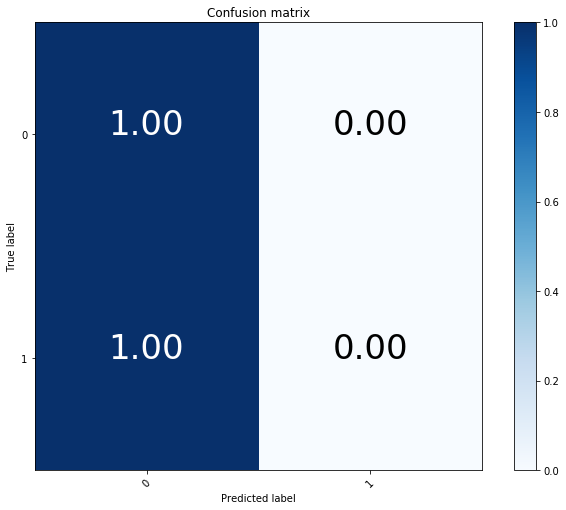

Displaying for obscene
0.951438544598


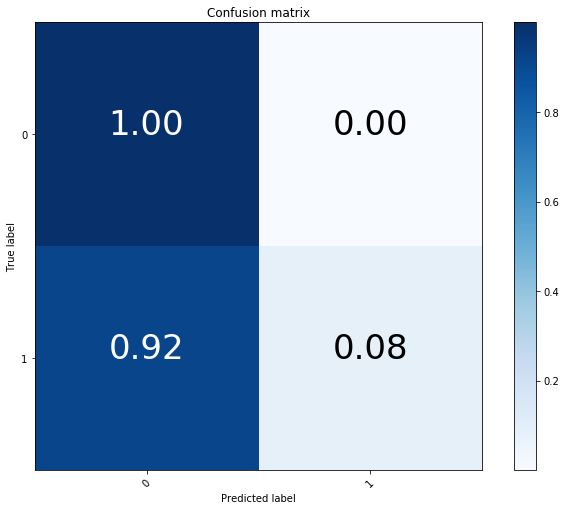

Displaying for threat
0.997017001836


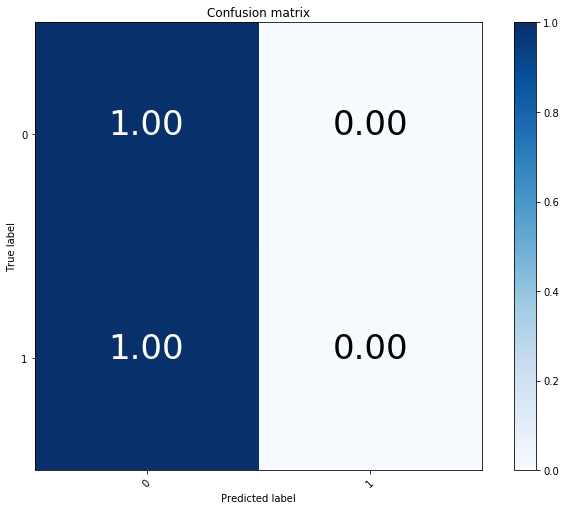

Displaying for insult
0.95203389087


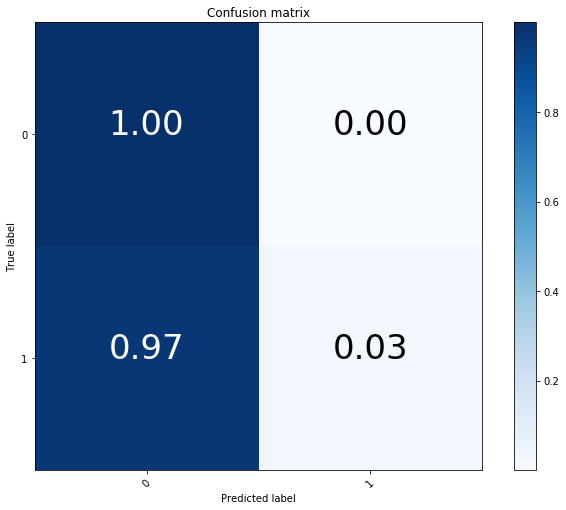

Displaying for identity_hate
0.991182608369


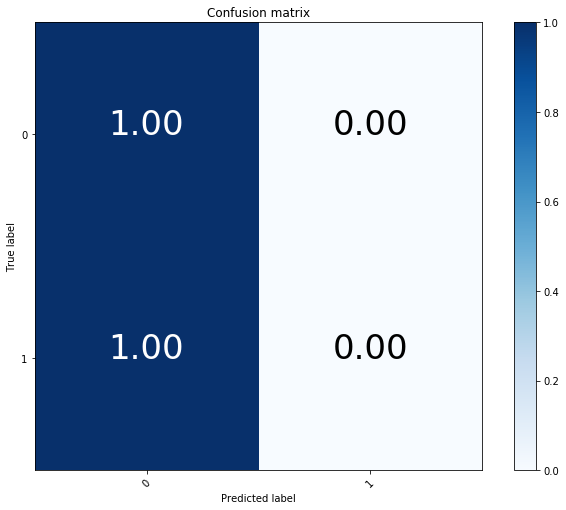

In [35]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("clf", MultinomialNB())
])

try_pipeline(pipeline)

Fitting toxic
Score: [-0.10547441 -0.10625707 -0.10763638 -0.10501599 -0.10709022]
Fitting severe_toxic
Score: [-0.0293067  -0.02819303 -0.02947413 -0.02835366 -0.0280129 ]
Fitting obscene
Score: [-0.06324583 -0.0626331  -0.05679921 -0.05856051 -0.05976261]
Fitting threat
Score: [-0.0090247  -0.00918264 -0.01022706 -0.00994208 -0.00866742]
Fitting insult
Score: [-0.07926311 -0.07951876 -0.07631599 -0.07620769 -0.07678007]
Fitting identity_hate
Score: [-0.02547826 -0.02630966 -0.02714737 -0.0264579  -0.02617008]
Displaying for toxic
0.961584498436


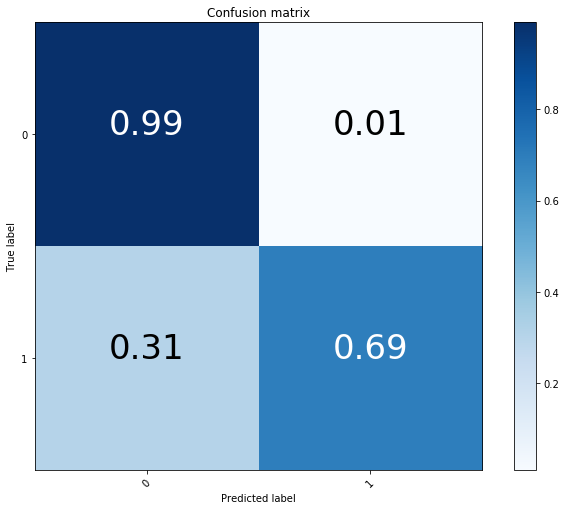

Displaying for severe_toxic
0.990587262096


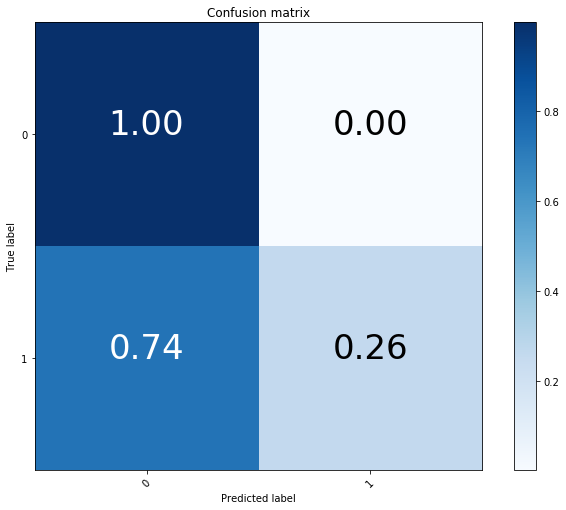

Displaying for obscene
0.980065300086


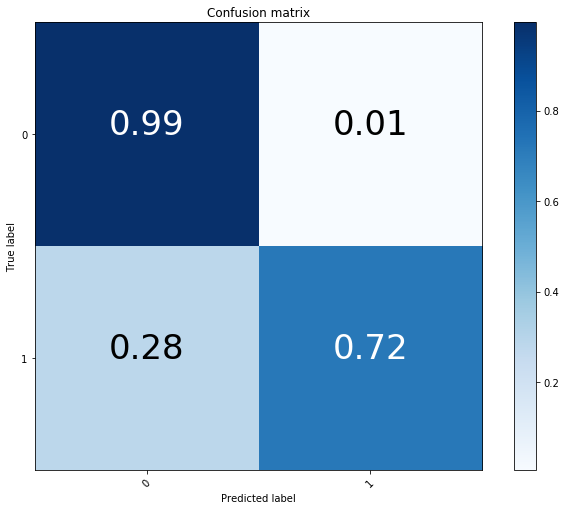

Displaying for threat
0.997286474359


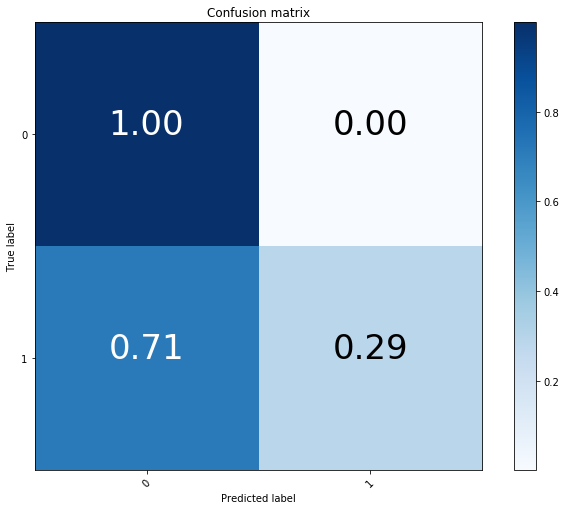

Displaying for insult
0.972482468619


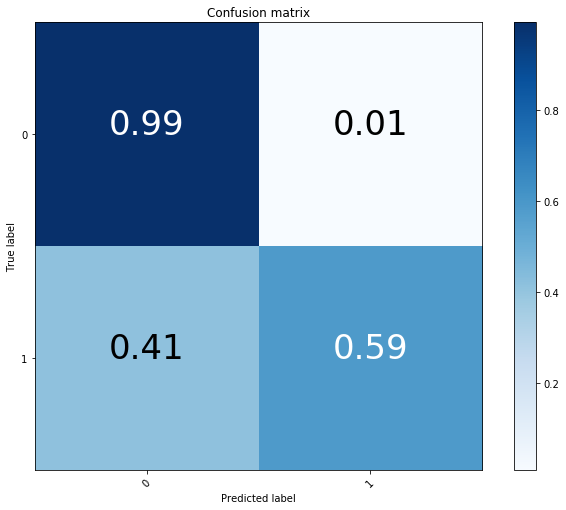

Displaying for identity_hate
0.992273032067


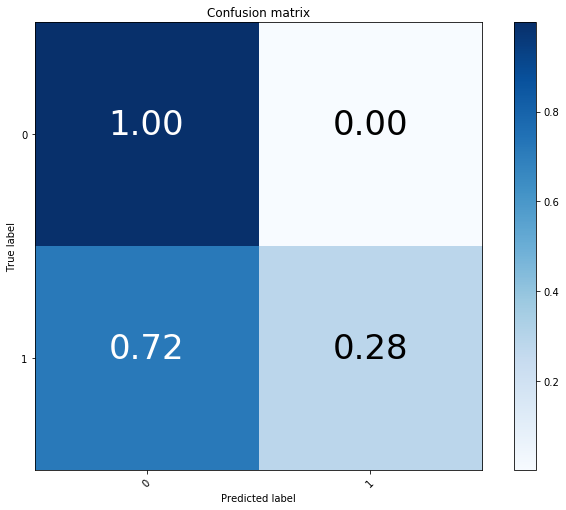

In [78]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("clf", CalibratedClassifierCV(LinearSVC()) ) # http://scikit-learn.org/stable/modules/calibration.html
])

try_pipeline(pipeline)

Fitting toxic
Score: [-0.11423159 -0.11407928 -0.11527601 -0.11221103 -0.11452935]
Fitting severe_toxic
Score: [-0.03050397 -0.0295986  -0.03089221 -0.02974798 -0.029506  ]
Fitting obscene
Score: [-0.06671467 -0.0665728  -0.06143632 -0.0632647  -0.06360394]
Fitting threat
Score: [-0.00951692 -0.00987914 -0.01068061 -0.01013299 -0.00924158]
Fitting insult
Score: [-0.08314688 -0.08455926 -0.08158286 -0.0817869  -0.0821653 ]
Fitting identity_hate
Score: [-0.0269158  -0.02790386 -0.02828662 -0.02718617 -0.02782958]
Displaying for toxic
0.958620300681


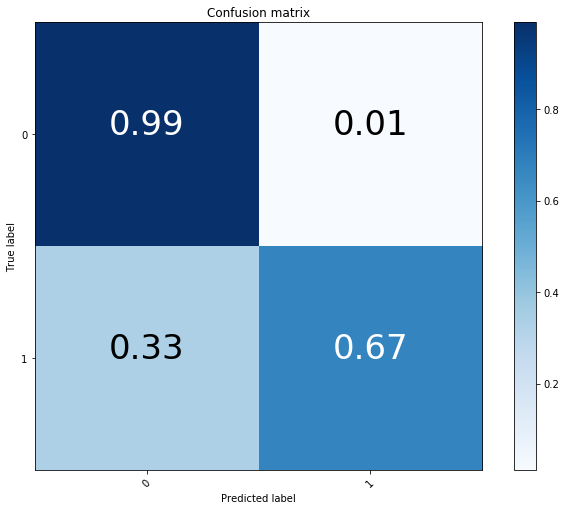

Displaying for severe_toxic
0.990317789573


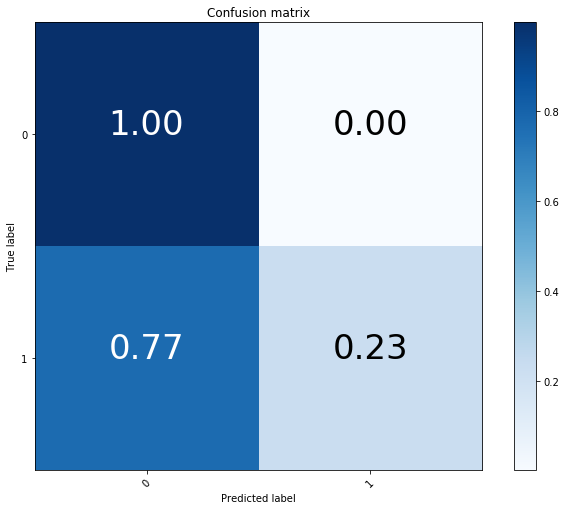

Displaying for obscene
0.978592601413


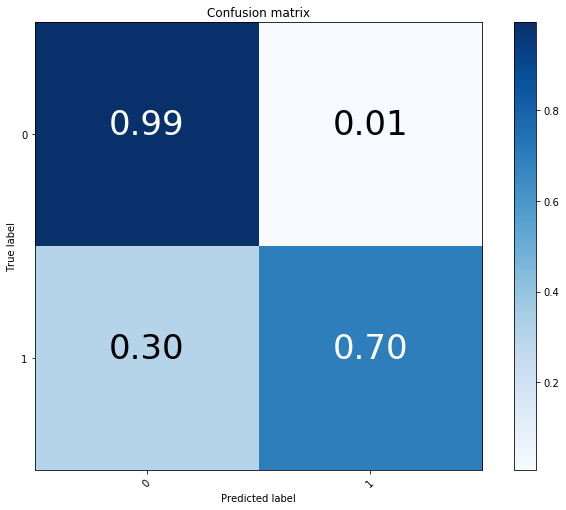

Displaying for threat
0.997230073134


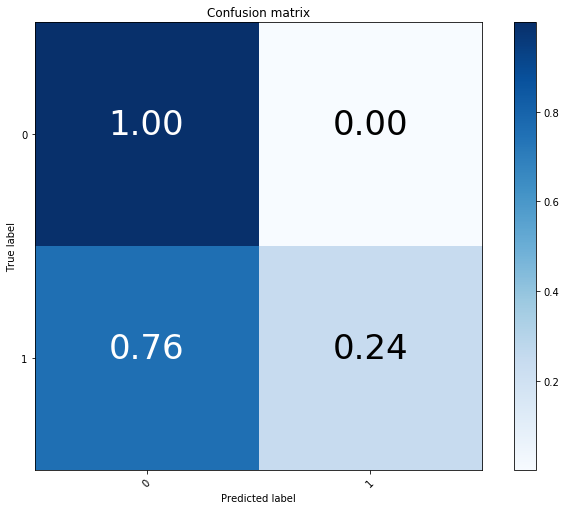

Displaying for insult
0.970558560139


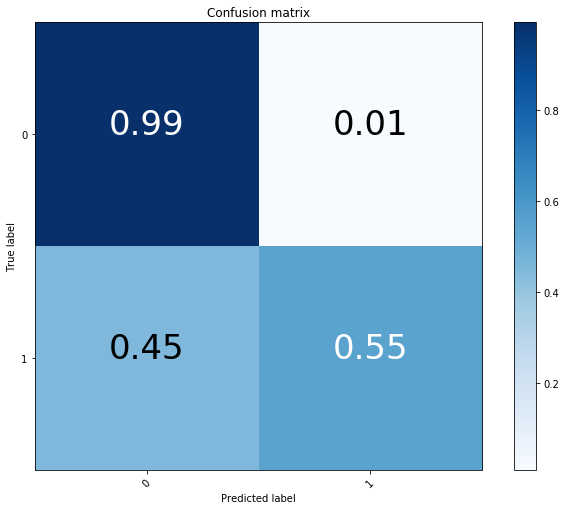

Displaying for identity_hate
0.991865689881


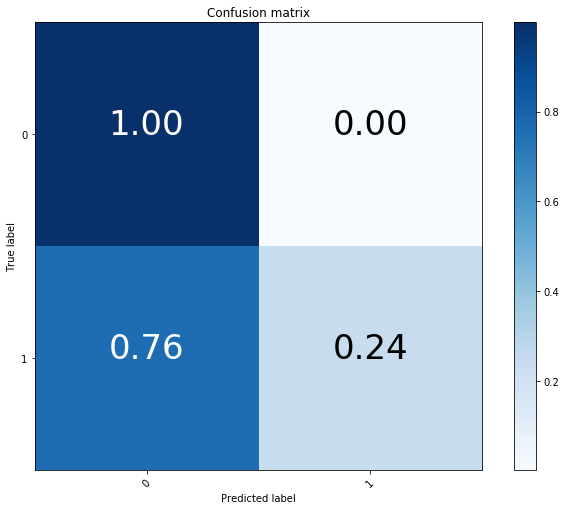

In [93]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("scale", MaxAbsScaler()),
    ("clf", CalibratedClassifierCV(LinearSVC()) )
])

try_pipeline(pipeline)

Fitting toxic
Score: [-0.11059316 -0.11138585 -0.11316617 -0.10963117 -0.11134898]
Fitting severe_toxic
Score: [-0.03123635 -0.02931052 -0.03112043 -0.02930727 -0.02950522]
Fitting obscene
Score: [-0.0639572  -0.06238032 -0.05615045 -0.0588706  -0.0598454 ]
Fitting threat
Score: [-0.01156245 -0.01211338 -0.01294452 -0.01339927 -0.01106078]
Fitting insult
Score: [-0.08234457 -0.08100115 -0.07722693 -0.07678513 -0.07743103]
Fitting identity_hate
Score: [-0.02822079 -0.02938928 -0.03076301 -0.03085033 -0.02900893]
Displaying for toxic
0.959409917842


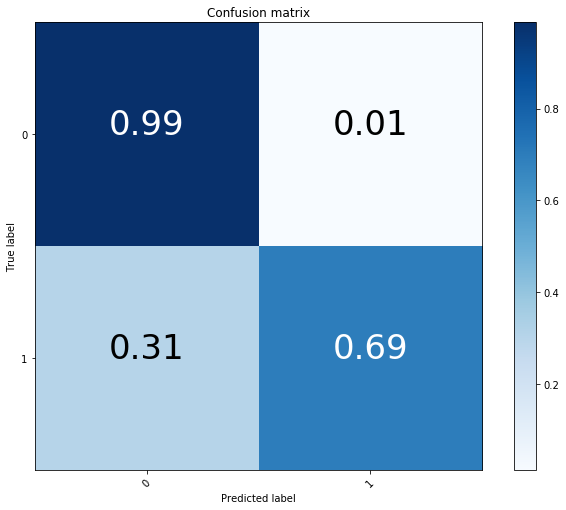

Displaying for severe_toxic
0.990480726448


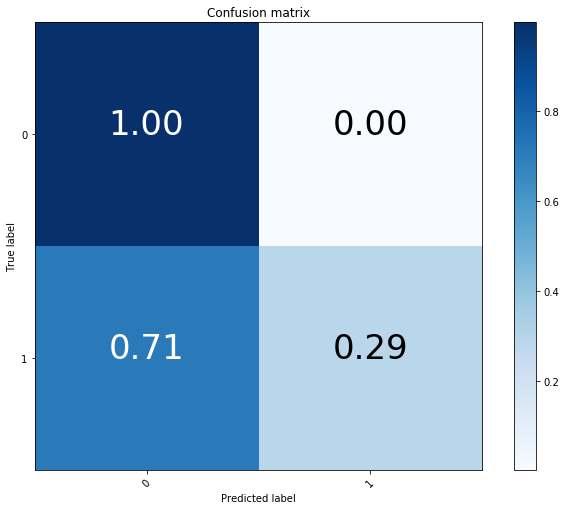

Displaying for obscene
0.979187947685


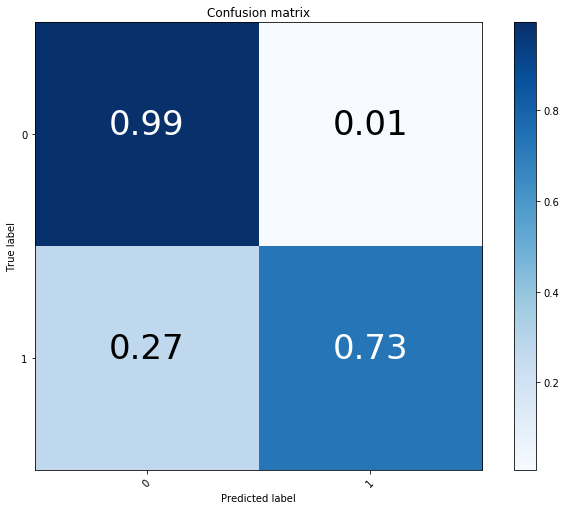

Displaying for threat
0.997129804288


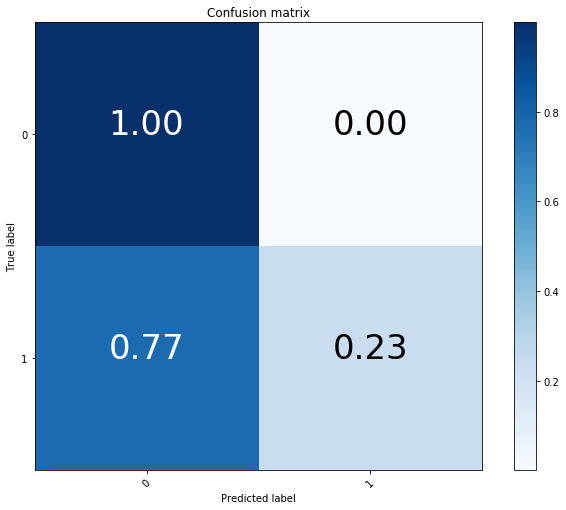

Displaying for insult
0.972595271071


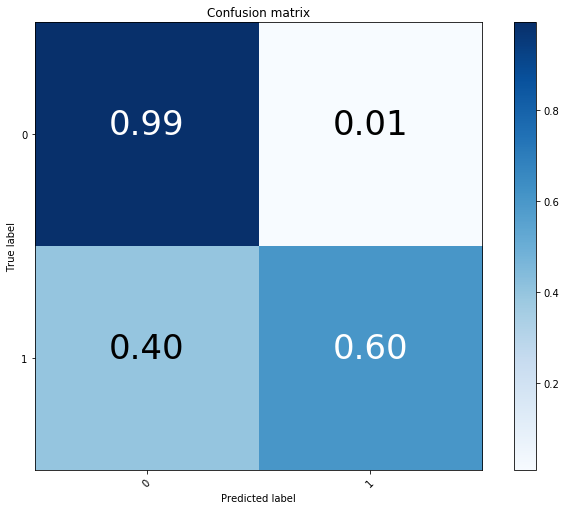

Displaying for identity_hate
0.992072494376


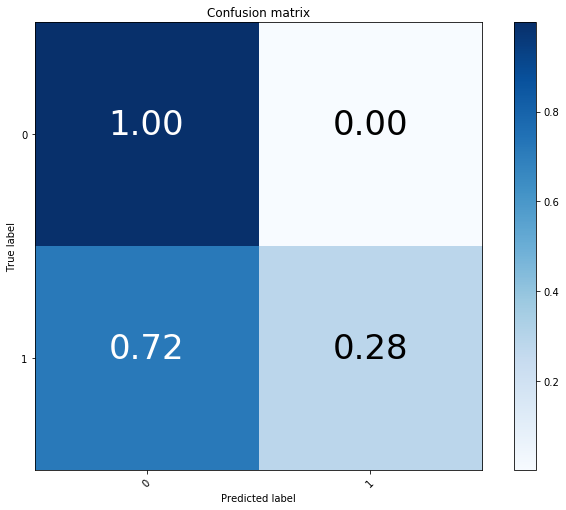

In [85]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("clf", CalibratedClassifierCV(RidgeClassifier()) )
])

try_pipeline(pipeline)

In [101]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer

stem = SnowballStemmer('english')

train["stemmed"] = train["comment_text"].apply(lambda t: " ".join([stem.stem(w) for w in t.split()])) 

Fitting toxic
Score: [-0.10672292 -0.10557809 -0.10772228 -0.10521328 -0.10732641]
Fitting severe_toxic
Score: [-0.02905929 -0.028055   -0.02917674 -0.02818099 -0.02831984]
Fitting obscene
Score: [-0.06310108 -0.06328714 -0.05689295 -0.05858012 -0.06048679]
Fitting threat
Score: [-0.00927095 -0.00949745 -0.01050982 -0.01022337 -0.00883588]
Fitting insult
Score: [-0.07964107 -0.08049207 -0.07636803 -0.07695133 -0.07805472]
Fitting identity_hate
Score: [-0.02504662 -0.02608231 -0.02749478 -0.02641455 -0.02586384]
Displaying for toxic
0.961559431225


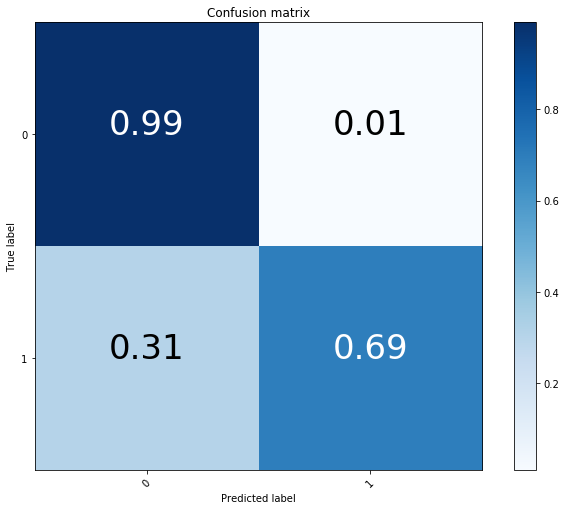

Displaying for severe_toxic
0.990681264139


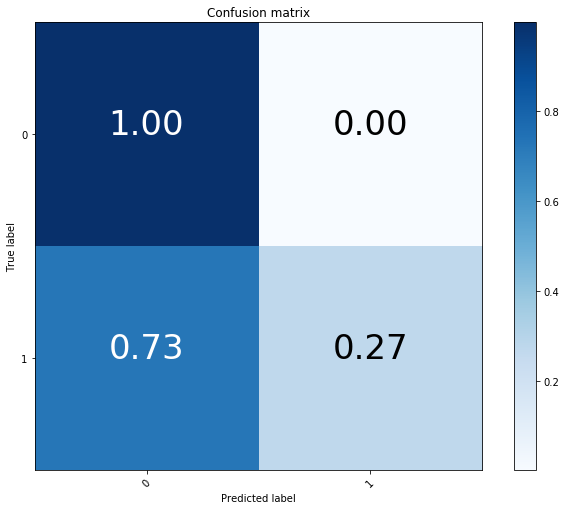

Displaying for obscene
0.979990098451


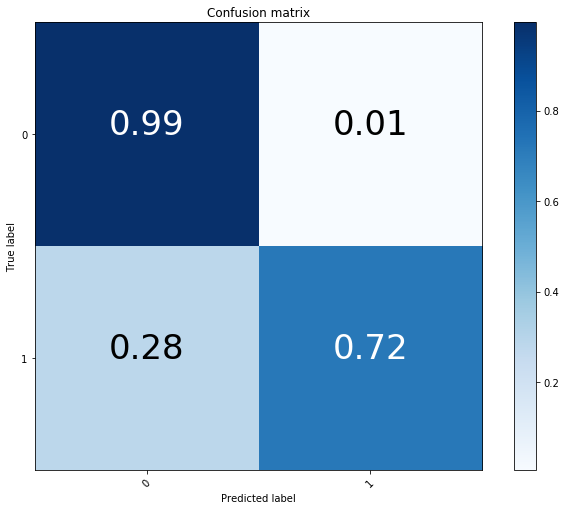

Displaying for threat
0.997198739119


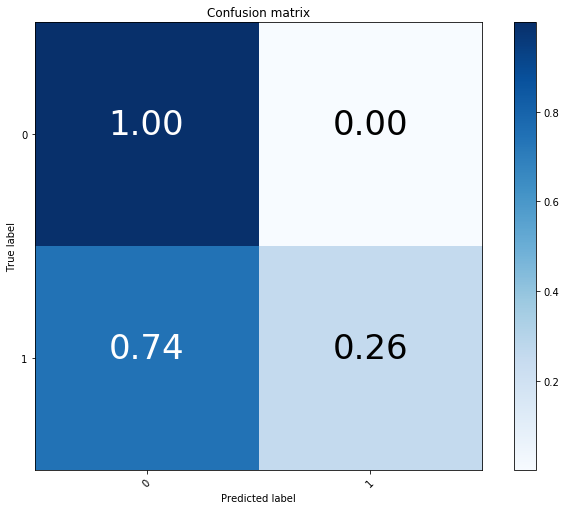

Displaying for insult
0.971899655953


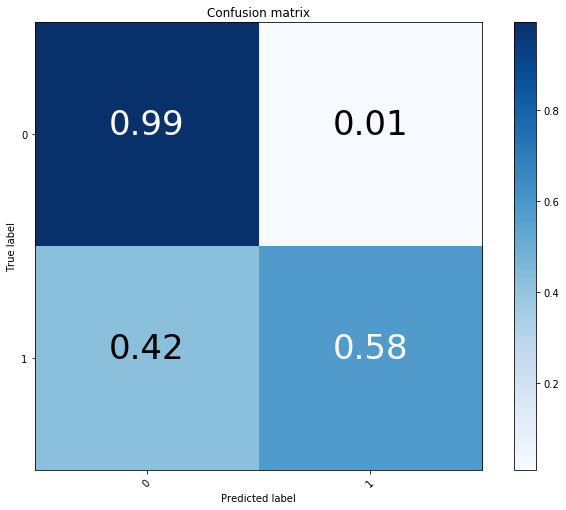

Displaying for identity_hate
0.992285565673


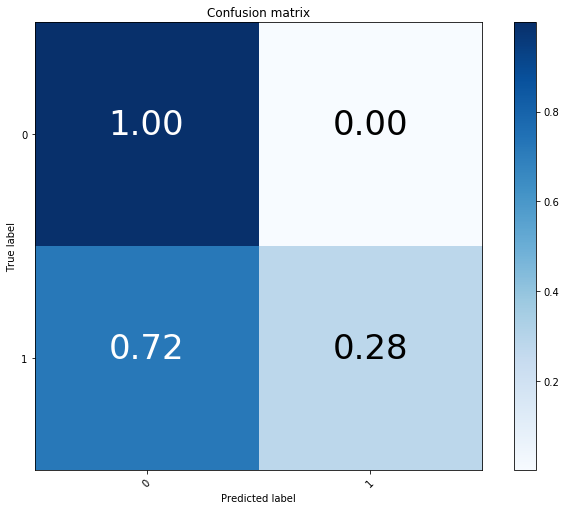

In [106]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("clf", CalibratedClassifierCV(LinearSVC()) )
])
try_pipeline(pipeline, text="stemmed")

Изглежда, че baseline модела използващ LinearSVC + calibration, се справя по-добре от чиста/с регуларизация логистична регресия. Стеминга също не показа подобрения и затова ще пробвам да оптимизирам модела чрез random search по хиперпараметри


In [108]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [119]:
params_count_word = {"vect__ngram_range": [(1,1), (1,2), (1,3)],
                      "vect__analyzer": ['word'],
                      "vect__max_df":[1.0, 0.9,0.5],
                      "vect__min_df":[2, 3, 5, 10],
                      "vect__lowercase": [False, True],
                      "vect__stop_words": [None, stopwords]}

In [128]:
pipeline = Pipeline([
    ("vect",TfidfVectorizer()),
    ("clf", CalibratedClassifierCV(LinearSVC()) )
])

random_search = RandomizedSearchCV(pipeline, param_distributions=params_count_word, 
                                       scoring='neg_log_loss',
                                       n_iter=10, cv=3, n_jobs=-1)


In [129]:
results = []
param_per_model = []
for label in target_labels:
    print("Fitting {}".format(label))
    random_search.fit(train["comment_text"],train[label])
    print(random_search.best_params_, random_search.best_score_)
    results.append(random_search.cv_results_)
    param_per_model.append(random_search.best_params_)
    

Fitting toxic
{'vect__analyzer': 'word', 'vect__min_df': 3, 'vect__lowercase': True, 'vect__ngram_range': (1, 3), 'vect__stop_words': None, 'vect__max_df': 0.9} -0.107721507323
Fitting severe_toxic
{'vect__analyzer': 'word', 'vect__min_df': 10, 'vect__lowercase': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__max_df': 0.5} -0.0290470519718
Fitting obscene
{'vect__analyzer': 'word', 'vect__min_df': 2, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until

In [134]:
preds = np.zeros( (test.shape[0], len(target_labels)))
preds.shape

(153164, 6)

In [141]:
for i,label in enumerate(target_labels):
    print("Predicting for {}".format(label))
    params = {key.replace("vect__", ""):val for key,val in param_per_model[i].items()}
    vectorizer = TfidfVectorizer(**params)
    vectorizer.fit(corpus)
    
    train_tf_idf = vectorizer.transform(train["comment_text"])
    model = CalibratedClassifierCV(LinearSVC())
    model.fit(train_tf_idf, train[label])
    
    test_tf_idf = vectorizer.transform(test["comment_text"])
    predicted = model.predict_proba(test_tf_idf)[:,1]
    preds[:,i] = predicted
        

Predicting for toxic
Predicting for severe_toxic
Predicting for obscene
Predicting for threat
Predicting for insult
Predicting for identity_hate


In [142]:
preds[0]

array([ 0.99994987,  0.16803001,  0.99980936,  0.0593846 ,  0.95899671,
        0.22424284])

In [143]:
submission = pd.DataFrame(data=preds,columns=target_labels,index=test["id"] )
submission[:5]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.999950,0.168030,0.999809,0.059385,0.958997,0.224243
0000247867823ef7,0.007056,0.001756,0.002138,0.000175,0.008231,0.001992
00013b17ad220c46,0.015199,0.003587,0.008947,0.000438,0.011786,0.002915
00017563c3f7919a,0.002208,0.006449,0.004900,0.000711,0.002027,0.000532
00017695ad8997eb,0.010323,0.002634,0.002989,0.001346,0.007563,0.000992


In [144]:
submission.to_csv("./submission_tf_lsvc.csv")